## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [40]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# # save model checkpoints
# !mkdir ./ckpts

# !kaggle datasets download -d samfc10/vesuvius-zarr-files

In [41]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os,cv2
import gc
import sys
import random
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

# sys.path.append("/kaggle/input/resnet3d")
ROOT_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection/'
sys.path.append(ROOT_DIR)
from resnet3d import generate_model

### Config

In [42]:
DATA_DIR = ROOT_DIR
# DATA_DIR = "/kaggle/input/vesuvius-zarr-files/"
LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 64
NUM_WORKERS = 8
CROP_SIZE = 224
Z_START = 26
Z_DIMS = 12
TRAIN_FRAGMENTS = ["1", "3"]
TEST_FRAGMENT = "2"
MODEL_DEPTH = 34
MAX_PIXEL_VALUE = 2 ** 16 - 1
RESIZE_HEIGHT = 4800
COMP_DATASET_PATH = "/home/fummicc1/codes/competitions/kaggle-ink-detection/"

### Load data

In [43]:
def resize(img):
    current_height, current_width = img.shape[:2]
    aspect_ratio = current_width / current_height
    new_height = RESIZE_HEIGHT
    new_width = int(new_height * aspect_ratio)
    new_size = (new_width, new_height)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

In [44]:
def load_mask(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/mask.png", 0) // 255    
    img = resize(img)    
    return img

def load_labels(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/inklabels.png", 0) // 255
    img = resize(img)
    return img

In [45]:
def calculate_mean_std(volume):
    mean_0 = np.mean(volume, axis=0)
    mean_1 = np.mean(mean_0, axis=0)
    std_0 = np.std(volume, axis=0)
    std_1 = np.std(std_0, axis=0)
    return mean_1, std_1


In [46]:
def read_image(mode, fragment_id):
    images = []

    # idxs = range(65)
    start = 0
    end = 65
    idxs = range(start, end)

    for i in tqdm(idxs):
        image = cv2.imread(COMP_DATASET_PATH + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", -1)
        # image = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", 0)
        
        # print(image.max())
        image = resize(image).astype(np.uint16)     
        # print(image.max())

        # pad0 = (CROP_SIZE - image.shape[0] % CROP_SIZE)
        # pad1 = (CROP_SIZE - image.shape[1] % CROP_SIZE)

        # image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)
        # print(image.max())
        images.append(image)
    images = np.stack(images, axis=2, dtype=np.uint16)
    # print(images.max())
    return images

In [47]:
FRAGMENTS_ZARR = {
    "1" : zarr.open(f"{ROOT_DIR}train-1.zarr", mode="rw"),
    "2" : zarr.open(f"{ROOT_DIR}/train-2.zarr", mode="rw"),
    "3" : zarr.open(f"{ROOT_DIR}/train-3.zarr", mode="rw")
}


In [48]:

for key in ["1", "2", "3"]:
    FRAGMENTS_ZARR[key]["surface_volume"] = read_image("train", key)
    FRAGMENTS_ZARR[key]["mask"] = load_mask("train", key)
    FRAGMENTS_ZARR[key]["truth"] = load_labels("train", key)
    
FRAGMENTS_SHAPE = {k : v.surface_volume.shape[:-1] for k, v in FRAGMENTS_ZARR.items()}

100%|██████████| 65/65 [00:04<00:00, 14.40it/s]


In [ ]:

ALL_MEAN_STD = {}
for key in ["1", "2", "3"]:
    img = FRAGMENTS_ZARR["1"]["surface_volume"][:, :, Z_START:Z_START+Z_DIMS]

    ALL_MEAN_STD[key] = calculate_mean_std(img)
    

In [ ]:
mean, std = ALL_MEAN_STD["1"]
mean, std

(array([16109.69208625, 16369.49254685, 16438.29656517, 16222.0806452 ,
        15666.63486809, 14798.66395805, 13742.26046082, 12686.97629522,
        11817.78381935, 11249.11221844, 11001.00114592, 11017.87967457]),
 array([2433.43871394, 2476.05812449, 2481.24664304, 2438.20475542,
        2340.0873872 , 2188.06798508, 2003.51993661, 1840.63669205,
        1757.65673004, 1747.70348844, 1746.66031272, 1724.24899866]))

In [ ]:
list(FRAGMENTS_ZARR["1"].keys())
np.unique(np.array(FRAGMENTS_ZARR["1"]["truth"]))

array([0, 1], dtype=uint8)

In [ ]:
def fetch_fragment_crop(id: str, y1, y2, x1, x2, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        img = FRAGMENTS_ZARR[id][key][y1:y2, x1:x2, z1:z2]
        return img.astype(np.uint16)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key][y1:y2, x1:x2]
        return img.astype(np.uint8)
    print("Error", key)

def fetch_fragment(id: str, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        img = FRAGMENTS_ZARR[id][key][:, :, z1:z2]
        return img.astype(np.uint16)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key]
        return img.astype(np.uint8)

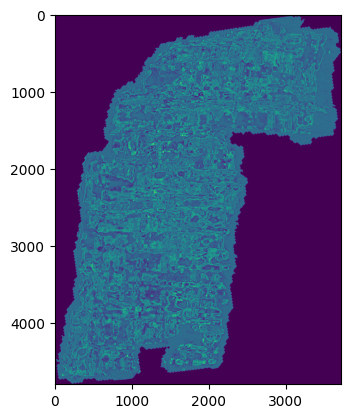

In [ ]:
plt.imshow(FRAGMENTS_ZARR["1"]["surface_volume"][:,:,0])

### Visualise input

In [ ]:
fragment_id = FRAGMENTS_ZARR["1"]
x, y = 800, 800

fragment_cropped = fetch_fragment_crop("1", y, y+CROP_SIZE, x, x+CROP_SIZE, Z_START, Z_START+Z_DIMS)
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1) / 255, "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from float64 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 256.70588235294116]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 256.1411764705882]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 251.66666666666666]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 242.5686274509804]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 249.78823529411764]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 256.988235

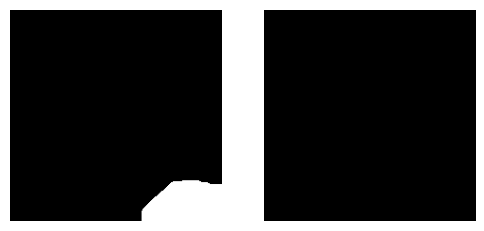

In [ ]:
mask_cropped = fragment_id.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment_id.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
# del fragment_id, fragment_cropped, mask_cropped, ir_cropped
# gc.collect()

### Dataloaders

In [ ]:
class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment_id in fragments:
            H, W = FRAGMENTS_SHAPE[fragment_id]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    self.xys.append((fragment_id, x, y, W, H))
        
    def __getitem__(self, i):
        fragment_id, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-32 if x1 != 0 else 0, 32)
        y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
            
        # print("x1: ", x1, " x2: ", x2, " y1: ", y1, " y2: ", y2)
        
        frag_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, z1, z2)
        mask_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, key="truth")[:, :, np.newaxis]
        
        performed = A.Compose([
            A.HorizontalFlip(p=0.3), # 水平方向に反転
            A.VerticalFlip(p=0.3), # 水平方向に反転
            A.RandomRotate90(p=0.3),
            A.ShiftScaleRotate(p=0.3),
        ])(image=frag_crop, mask=mask_crop)
        frag_crop = performed["image"]
        mask_crop = performed["mask"]
        
        mean, std = ALL_MEAN_STD[fragment_id]
        frag_crop = (frag_crop - mean) / std
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).permute(2, 0, 1)        
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).permute(2, 0, 1)
        
        assert frag_crop.shape[0] == Z_DIMS
        
        return {
            "images": frag_crop,
            "labels": mask_crop
        }

    def __len__(self):
        return len(self.xys)

In [ ]:
# ALL_MEAN_STD

In [ ]:
class VesuviusVal(Dataset):
    def __init__(self, fragment_id):
        self.fragment_id = fragment_id
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment_id]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, z1, z2)
        
        mask_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, key="truth")[:, :, np.newaxis]

        mean, std = ALL_MEAN_STD[self.fragment_id]
        
        frag_crop = (frag_crop - mean) / std
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).permute(2, 0, 1)        
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).permute(2, 0, 1)
        
        assert frag_crop.shape[0] == Z_DIMS
        
        return {
            "images": frag_crop,
            "labels": mask_crop,
            "locations": torch.tensor([x1, y1, x2, y2], dtype=torch.int32)
        }

    def __len__(self):
        return len(self.xys)

In [ ]:
def collate_train_fn(batch):
  return {
      'images': torch.stack([x['images'] for x in batch]),
      'labels': torch.stack([x['labels'] for x in batch])
}
  
  
def collate_val_fn(batch):
  return {
      'images': torch.stack([x['images'] for x in batch]),
      'labels': torch.stack([x['labels'] for x in batch]),
      'locations': torch.stack([x['locations'] for x in batch])
}

In [ ]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
    collate_fn=collate_train_fn,
    shuffle=True
)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(
    dataset_valid, 
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
    collate_fn=collate_val_fn,
    shuffle=False
)
n_valid = len(dataloader_valid)

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask
    
class SegModel(nn.Module):
    def __init__(self,model_depth=MODEL_DEPTH):
        super().__init__()
        self.encoder = generate_model(model_depth=MODEL_DEPTH, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        if x.ndim==4:
            x=x[:,None] # チャネルを追加
        
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))
        
   
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder=SegModel()
        weight_path = "r3d18_K_200ep.pth"
        if os.path.exists(weight_path):
            self.encoder.load_pretrained_weights(torch.load(weight_path)["state_dict"])

    def forward(self, images:torch.Tensor):
        #image.shape=(b,C,H,W)
        if images.ndim==4:
            images=images[:,None]
        # images=normalization(images)
        output = self.encoder(images)
        return output

In [ ]:
model = CustomModel()
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
model = model.cuda()

_IncompatibleKeys(missing_keys=['layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', 'layer1.2.bn2.running_mean', 'layer1.2.bn2.running_var', 'layer2.2.conv1.weight', 'layer2.2.bn1.weight', 'layer2.2.bn1.bias', 'layer2.2.bn1.running_mean', 'layer2.2.bn1.running_var', 'layer2.2.conv2.weight', 'layer2.2.bn2.weight', 'layer2.2.bn2.bias', 'layer2.2.bn2.running_mean', 'layer2.2.bn2.running_var', 'layer2.3.conv1.weight', 'layer2.3.bn1.weight', 'layer2.3.bn1.bias', 'layer2.3.bn1.running_mean', 'layer2.3.bn1.running_var', 'layer2.3.conv2.weight', 'layer2.3.bn2.weight', 'layer2.3.bn2.bias', 'layer2.3.bn2.running_mean', 'layer2.3.bn2.running_var', 'layer3.2.conv1.weight', 'layer3.2.bn1.weight', 'layer3.2.bn1.bias', 'layer3.2.bn1.running_mean', 'layer3.2.bn1.running_var', 'layer3.2.conv2.weight', 'layer3.2.bn2.weight', 'layer3.2.bn2.bias', 'layer3.2.bn2.run

### Competition metric (F0.5 Score)

In [ ]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [ ]:
scaler = amp.GradScaler()
criterion = smp.losses.FocalLoss(mode="binary")
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, min_lr=5e-5)

In [ ]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [ ]:
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = optimizer.param_groups[0]['lr']
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    for i, batches in pbar_train:
        fragments = batches["images"]
        masks = batches["labels"]
        fragments, masks = fragments.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))    
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, batches in pbar_val:
        fragments = batches["images"]
        masks = batches["labels"]
        xys = batches["locations"]
        fragments, masks = fragments.cuda(), masks.cuda()
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    scheduler.step(metrics=mloss_val)
    
    for threshold in np.arange(0.2, 0.65, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet{MODEL_DEPTH}_val_{TEST_FRAGMENT}_3d_seg_epoch_{epoch}.pt")

    if epoch == 30:
        break

Epoch 1/20  Mem : 5.56GB      0.0001  Loss: 0.1821: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]
Val Loss: 0.1515: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]

Threshold : 0.20	FBeta : 0.132493
Threshold : 0.25	FBeta : 0.132493
Threshold : 0.30	FBeta : 0.132493
Threshold : 0.35	FBeta : 0.132493
Threshold : 0.40	FBeta : 0.132493
Threshold : 0.45	FBeta : 0.161564
Threshold : 0.50	FBeta : 0.163327
Threshold : 0.55	FBeta : 0.014189
Threshold : 0.60	FBeta : 0.000000



Epoch 2/20  Mem : 6.83GB      0.0001  Loss: 0.1343: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]
Val Loss: 0.1312: 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]

Threshold : 0.20	FBeta : 0.132493
Threshold : 0.25	FBeta : 0.132493
Threshold : 0.30	FBeta : 0.132493
Threshold : 0.35	FBeta : 0.132493
Threshold : 0.40	FBeta : 0.138047
Threshold : 0.45	FBeta : 0.210274
Threshold : 0.50	FBeta : 0.163115
Threshold : 0.55	FBeta : 0.009375
Threshold : 0.60	FBeta : 0.000174



Epoch 3/20  Mem : 6.83GB      0.0001  Loss: 0.1154: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]
Val Loss: 0.1089: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]

Threshold : 0.20	FBeta : 0.132493
Threshold : 0.25	FBeta : 0.132493
Threshold : 0.30	FBeta : 0.132493
Threshold : 0.35	FBeta : 0.133778
Threshold : 0.40	FBeta : 0.188708
Threshold : 0.45	FBeta : 0.215890
Threshold : 0.50	FBeta : 0.049041
Threshold : 0.55	FBeta : 0.001499
Threshold : 0.60	FBeta : 0.000005



Epoch 4/20  Mem : 6.83GB      0.0001  Loss: 0.1054: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]
Val Loss: 0.0989: 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]

Threshold : 0.20	FBeta : 0.132493
Threshold : 0.25	FBeta : 0.132493
Threshold : 0.30	FBeta : 0.135602
Threshold : 0.35	FBeta : 0.166115
Threshold : 0.40	FBeta : 0.211716
Threshold : 0.45	FBeta : 0.175936
Threshold : 0.50	FBeta : 0.033496
Threshold : 0.55	FBeta : 0.001057
Threshold : 0.60	FBeta : 0.000000



Epoch 5/20  Mem : 6.83GB      0.0001  Loss: 0.0988: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]
Val Loss: 0.0896: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]

Threshold : 0.20	FBeta : 0.132493
Threshold : 0.25	FBeta : 0.132493
Threshold : 0.30	FBeta : 0.137218
Threshold : 0.35	FBeta : 0.201103
Threshold : 0.40	FBeta : 0.251569
Threshold : 0.45	FBeta : 0.204184
Threshold : 0.50	FBeta : 0.024191
Threshold : 0.55	FBeta : 0.000571
Threshold : 0.60	FBeta : 0.000000



Epoch 6/20  Mem : 6.83GB      0.0001  Loss: 0.0929: 100%|██████████| 9/9 [00:03<00:00,  3.00it/s]
Val Loss: 0.0862: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]

Threshold : 0.20	FBeta : 0.132493
Threshold : 0.25	FBeta : 0.133499
Threshold : 0.30	FBeta : 0.147748
Threshold : 0.35	FBeta : 0.210337
Threshold : 0.40	FBeta : 0.252797
Threshold : 0.45	FBeta : 0.159610
Threshold : 0.50	FBeta : 0.007865
Threshold : 0.55	FBeta : 0.000035
Threshold : 0.60	FBeta : 0.000000



Epoch 7/20  Mem : 6.83GB      0.0001  Loss: 0.0896: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]
Val Loss: 0.0908: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]

Threshold : 0.20	FBeta : 0.133387
Threshold : 0.25	FBeta : 0.135739
Threshold : 0.30	FBeta : 0.163585
Threshold : 0.35	FBeta : 0.209817
Threshold : 0.40	FBeta : 0.213419
Threshold : 0.45	FBeta : 0.041735
Threshold : 0.50	FBeta : 0.001277
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000



Epoch 8/20  Mem : 6.83GB      0.0001  Loss: 0.0861: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]
Val Loss: 0.0782: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]

Threshold : 0.20	FBeta : 0.132493
Threshold : 0.25	FBeta : 0.133603
Threshold : 0.30	FBeta : 0.207864
Threshold : 0.35	FBeta : 0.237268
Threshold : 0.40	FBeta : 0.265845
Threshold : 0.45	FBeta : 0.081568
Threshold : 0.50	FBeta : 0.000936
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000



Epoch 9/20  Mem : 6.83GB      0.0001  Loss: 0.0853: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]
Val Loss: 0.0792: 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]

Threshold : 0.20	FBeta : 0.132494
Threshold : 0.25	FBeta : 0.143470
Threshold : 0.30	FBeta : 0.215593
Threshold : 0.35	FBeta : 0.237493
Threshold : 0.40	FBeta : 0.272317
Threshold : 0.45	FBeta : 0.307890
Threshold : 0.50	FBeta : 0.050552
Threshold : 0.55	FBeta : 0.000068
Threshold : 0.60	FBeta : 0.000000



Epoch 10/20  Mem : 6.83GB      0.0001  Loss: 0.0837: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]
Val Loss: 0.0774: 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]


Threshold : 0.20	FBeta : 0.132493
Threshold : 0.25	FBeta : 0.134880
Threshold : 0.30	FBeta : 0.204631
Threshold : 0.35	FBeta : 0.254658
Threshold : 0.40	FBeta : 0.283378
Threshold : 0.45	FBeta : 0.226628
Threshold : 0.50	FBeta : 0.013322
Threshold : 0.55	FBeta : 0.000076
Threshold : 0.60	FBeta : 0.000000


Epoch 11/20  Mem : 6.83GB      0.0001  Loss: 0.0821: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]
Val Loss: 0.0727: 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]


Threshold : 0.20	FBeta : 0.132703
Threshold : 0.25	FBeta : 0.150846
Threshold : 0.30	FBeta : 0.225265
Threshold : 0.35	FBeta : 0.261905
Threshold : 0.40	FBeta : 0.328206
Threshold : 0.45	FBeta : 0.298289
Threshold : 0.50	FBeta : 0.026183
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000


Epoch 12/20  Mem : 6.83GB      0.0001  Loss: 0.0810: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]
Val Loss: 0.0814: 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]


Threshold : 0.20	FBeta : 0.132498
Threshold : 0.25	FBeta : 0.161582
Threshold : 0.30	FBeta : 0.224350
Threshold : 0.35	FBeta : 0.241162
Threshold : 0.40	FBeta : 0.264976
Threshold : 0.45	FBeta : 0.297953
Threshold : 0.50	FBeta : 0.307364
Threshold : 0.55	FBeta : 0.041785
Threshold : 0.60	FBeta : 0.000000


Epoch 13/20  Mem : 6.83GB      0.0001  Loss: 0.0796: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]
Val Loss: 0.0723: 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]


Threshold : 0.20	FBeta : 0.133054
Threshold : 0.25	FBeta : 0.210451
Threshold : 0.30	FBeta : 0.232967
Threshold : 0.35	FBeta : 0.261555
Threshold : 0.40	FBeta : 0.310294
Threshold : 0.45	FBeta : 0.366091
Threshold : 0.50	FBeta : 0.391773
Threshold : 0.55	FBeta : 0.184420
Threshold : 0.60	FBeta : 0.007282


Epoch 14/20  Mem : 6.83GB      0.0001  Loss: 0.0790: 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]
Val Loss: 0.0790: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


Threshold : 0.20	FBeta : 0.133331
Threshold : 0.25	FBeta : 0.190371
Threshold : 0.30	FBeta : 0.221035
Threshold : 0.35	FBeta : 0.236281
Threshold : 0.40	FBeta : 0.262796
Threshold : 0.45	FBeta : 0.314073
Threshold : 0.50	FBeta : 0.299143
Threshold : 0.55	FBeta : 0.021794
Threshold : 0.60	FBeta : 0.000000


Epoch 15/20  Mem : 6.83GB      0.0001  Loss: 0.0767: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]
Val Loss: 0.0687: 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


Threshold : 0.20	FBeta : 0.132692
Threshold : 0.25	FBeta : 0.206447
Threshold : 0.30	FBeta : 0.251268
Threshold : 0.35	FBeta : 0.304732
Threshold : 0.40	FBeta : 0.350218
Threshold : 0.45	FBeta : 0.361770
Threshold : 0.50	FBeta : 0.279497
Threshold : 0.55	FBeta : 0.036257
Threshold : 0.60	FBeta : 0.000005


Epoch 16/20  Mem : 6.83GB      0.0001  Loss: 0.0773: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]
Val Loss: 0.0760: 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]


Threshold : 0.20	FBeta : 0.132772
Threshold : 0.25	FBeta : 0.206923
Threshold : 0.30	FBeta : 0.278874
Threshold : 0.35	FBeta : 0.308789
Threshold : 0.40	FBeta : 0.217843
Threshold : 0.45	FBeta : 0.104119
Threshold : 0.50	FBeta : 0.029725
Threshold : 0.55	FBeta : 0.003742
Threshold : 0.60	FBeta : 0.000000


Epoch 17/20  Mem : 6.83GB      0.0001  Loss: 0.0769: 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]
Val Loss: 0.0657: 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]


Threshold : 0.20	FBeta : 0.141729
Threshold : 0.25	FBeta : 0.230510
Threshold : 0.30	FBeta : 0.254411
Threshold : 0.35	FBeta : 0.306488
Threshold : 0.40	FBeta : 0.361763
Threshold : 0.45	FBeta : 0.400767
Threshold : 0.50	FBeta : 0.360998
Threshold : 0.55	FBeta : 0.147383
Threshold : 0.60	FBeta : 0.011049


Epoch 18/20  Mem : 6.83GB      0.0001  Loss: 0.0752: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]
Val Loss: 0.0761: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]


Threshold : 0.20	FBeta : 0.134729
Threshold : 0.25	FBeta : 0.219473
Threshold : 0.30	FBeta : 0.276159
Threshold : 0.35	FBeta : 0.198611
Threshold : 0.40	FBeta : 0.046430
Threshold : 0.45	FBeta : 0.007122
Threshold : 0.50	FBeta : 0.000000
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000


Epoch 19/20  Mem : 6.83GB      0.0001  Loss: 0.0751: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]
Val Loss: 0.0709: 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]


Threshold : 0.20	FBeta : 0.135823
Threshold : 0.25	FBeta : 0.201808
Threshold : 0.30	FBeta : 0.241138
Threshold : 0.35	FBeta : 0.289848
Threshold : 0.40	FBeta : 0.339504
Threshold : 0.45	FBeta : 0.349103
Threshold : 0.50	FBeta : 0.280778
Threshold : 0.55	FBeta : 0.145936
Threshold : 0.60	FBeta : 0.031812


Epoch 20/20  Mem : 6.83GB      0.0001  Loss: 0.0746: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]
Val Loss: 0.0686: 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]


Threshold : 0.20	FBeta : 0.133165
Threshold : 0.25	FBeta : 0.217307
Threshold : 0.30	FBeta : 0.241228
Threshold : 0.35	FBeta : 0.281602
Threshold : 0.40	FBeta : 0.341175
Threshold : 0.45	FBeta : 0.364916
Threshold : 0.50	FBeta : 0.308710
Threshold : 0.55	FBeta : 0.164303
Threshold : 0.60	FBeta : 0.026419
